In [3]:
# Import necessary libraries
from qutip import *
from scipy.optimize import minimize
import numpy as np
import math
import matplotlib.pyplot as plt
from CP_Functions import *

In [7]:
# Create the model Hamiltonian in two parts to allow for a complex conjugate in the lower diagonal
dims = 5
ustate = basis(dims, 0)
eigenbasis = np.zeros((dims,dims)).astype(np.complex128)  # This will be used to generate the 3 parts of the Hamiltoninan
for l in range(dims):
    eigenbasis[l][l] = 1.

lambda_j = [np.sqrt(j) for j in range(dims-1)]              # Coefficents for the non-diagonal terms

delta_2 = -2*np.pi*0.3
delta = [delta_2*(j+1)*(j+2)/2 for j in range(dims-2)]      # Coefficents for the diagonal terms

amp = np.pi
sigma = -0.75*2*np.pi/delta_2                               # Hyperparameters
t_g = 4*sigma

P_j_inter,P_j = np.zeros((dims,dims,dims)),[]               # arrays to store the Hamiltonian generating terms
sigma_x,sigma_y = [],[]
for j in range(dims):
    P_j_inter[j,j,j] = 1.                          
    P_j.append(Qobj(P_j_inter[j]))
    if j+1<dims:
     sigma_x.append(Qobj(np.tensordot(eigenbasis[j],eigenbasis[j+1],axes=0)))
     sigma_y.append(Qobj(np.tensordot(eigenbasis[j+1],eigenbasis[j],axes=0)))


H0,H1,H2 = 0,0,0
for j in range(dims-2):
   H0 += P_j[j+2]*delta[j]

for j in range(dims - 1):

    H1 += sigma_x[j]/2 * np.sqrt(j+1)

    H2 += sigma_y[j]/2 * np.sqrt(j+1)


In [8]:
def Gaussian(t,eps,nums,*args):         # A gaussian shaped function, taken from https://arxiv.org/abs/1011.1949 equation (3.2)
    global sigma
    amp = np.pi
    t_g = 4*sigma/nums
    
    return amp*(1+eps)*(np.exp(-((t-t_g/2)**2)/(2*sigma**2))-np.exp(-((t_g)**2)/(8*sigma**2)))/(np.sqrt(2*np.pi*sigma**2)*math.erf(t_g/(np.sqrt(8)*sigma))-t_g*np.exp(-t_g**2/(8*sigma**2)))

def sin(t,eps,number_of_pulses):  # A sin^2 functions
    sigma = 2.5

    t_g = 4*sigma/number_of_pulses
    
    return 2*np.pi/2.5*(1+eps)*np.sin(t/t_g*np.pi)**2
def pravo(t,eps,number_of_pulses):     # A constant function
     global sigma

     return (1+eps)

def dragi(x,args):          # A function responsible for the pulse magnitude and the phase
    alpha = args['alpha']
    eps = args['eps']
    phase =  args['phase']
    nums = args['nums']

    return alpha*pravo(x,eps,nums)*np.exp(-1j*phase)

def drag(x,args):            # The conjugate of the above function
    alpha = args['alpha']
    eps = args['eps']
    phase =  args['phase']
    nums = args['nums']
    
    return alpha*pravo(x,eps,nums)*np.exp(1j*phase)

def funmim_operator(x,*args):    # Function that minimizes the infidelity between a CP generated propegator and a desired gate
    global delta_2,sigma,dims,loss
    t_g = 4*sigma
    H = args[0][0]
    operator = args[0][5]
    propag = []
    number_of_pulses = args[0][6]
    opo = 0.
    
    for eps in [-0.03,0.,0.03]:
     propag = []
     for j in range(len(x)//2):
       propag.append(np.array(propagator(H, t_g/number_of_pulses, [],args= {'alpha':x[j],'eps': eps,'phase': x[j+len(x)//2],'nums': number_of_pulses})))
    
     U_f = np.diag(np.ones(dims)).astype(np.complex128)
     for m in range(len(x)//2):
        U_f = np.matmul(propag[m],U_f)
     state = np.array(basis(dims, 0)).astype(np.complex128)
     state_evolved = U_f@state*np.conj(U_f@state)

     opo += optimal_trace(U_f,operator,n = 2)
    
    loss.append(opo)
    return  opo

def funmim(x,*args):       # A function that optimizes population transfer
    global delta_2,sigma,loss
    
    number_of_pulses = args[0][7]
    amp = np.pi
    t_g = 4*sigma
    H = args[0][0]
    times = np.linspace(0,t_g/number_of_pulses,2)
    P_j_1, P_j_2, P_j_3 = args[0][1],args[0][2],args[0][4]
    ustate = args[0][3]
    operator = args[0][5]
    upstate = basis(dims, 0)
    ara_neshta = [0.,0.]
    epsillon = [-0.05,0.,0.05]

    for eps in epsillon:
     propag = []
     for j in range(len(x)//2):
       propag.append(np.array(propagator(H, t_g/number_of_pulses, [],args= {'alpha':x[j],'eps': eps,'phase': x[j+len(x)//2],'nums': number_of_pulses})))
    
     U_f = np.diag(np.ones(dims)).astype(np.complex128)
     for m in range(len(x)//2):
        U_f = np.matmul(propag[m],U_f)
        
     state = np.array(basis(dims, 0)).astype(np.complex128)
     state_evolved = U_f@state*np.conj(U_f@state)
     
     ara_neshta[0] += np.abs(1-float(state_evolved[1].real)) 
     ara_neshta[1] += np.abs(0.5-float(state_evolved[1].real)) + np.abs(0.5-float(state_evolved[0].real)) 
    
    half_pop = args[0][6]
    if half_pop:
      loss.append(ara_neshta[1]/len(epsillon))
      return ara_neshta[1]/len(epsillon)
    else:
      loss.append(ara_neshta[0]/len(epsillon))
      return ara_neshta[0]/len(epsillon) 

In [ ]:
H = [H0,[H1,drag],[H2,dragi]] # Final Hamiltonian
t_g = 4*sigma

loss = []

ustate = basis(dims, 0)    # Initial state
operator = create_gate('sqrtX',dims)         # Target gate
pop_transfer = False               # Controls whether to optimize fidelity or population transfer 
half_pop = False            # Optimize for half pop. or complete pop. transfer
 
for number_of_pulses in [8]:
 for j in range(1):
  times = np.linspace(0,t_g/number_of_pulses,2)               # Points in which to integrate the system

  ustate = basis(dims, 0)
  if pop_transfer:
    res_X_gate = minimize(funmim,np.random.rand(number_of_pulses*2),args = [H,P_j[0], P_j[1],ustate,P_j[0],operator,half_pop,number_of_pulses])   # Minimze function
    
    #Evaluate the solution
    for j in range(len(res_X_gate.x)//2):
      result = sesolve(H, ustate, times, [],args= {'alpha':res_X_gate.x[j],'eps': 0.,'phase':res_X_gate.x[j+len(res_X_gate.x)//2],'nums': number_of_pulses})
      ustate = result.states[-1]
  
    aramax = (result.states[-1][1]*np.conj(result.states[-1][1])).real
    if half_pop:
      print(np.abs(0.5-float((result.states[-1][0]*np.conj(result.states[-1][0])).real)) + np.abs(0.5-float((result.states[-1][1]*np.conj(result.states[-1][1])).real)))
    else:
      print(np.abs(1-float(aramax)))

    print(res_X_gate.x)
  else:
    res_X_gate = minimize(funmim_operator,np.random.rand(number_of_pulses*2),args = [H,P_j[0], P_j[1],ustate,P_j[0],operator,number_of_pulses])
    #Evaluate the solution
    propag = []
    for j in range(len(res_X_gate.x)//2):
      propag.append(np.array(propagator(H, t_g/number_of_pulses, args= {'alpha':res_X_gate.x[j],'eps': 0.,'phase':res_X_gate.x[j+len(res_X_gate.x)//2],'nums': number_of_pulses})))

    U_f = np.diag(np.ones(dims)).astype(np.complex128)

    for m in range(number_of_pulses):
      U_f = np.matmul(propag[m],U_f)
    print(optimal_trace(U_f,operator,n = 2))
    print(res_X_gate.x)


In [5]:
pop_transfer_short = np.array([0.51724796, 0.3452526 , 0.34051733 ,0.29540373 ,0.11049604 ,0.41856604,
 0.27014951 ,0.52664331, 0.47547968 ,0.96407788])

number_of_pulses = len(pop_transfer_short)//2

Area =  3.2178353199999994
[(-0.2, 0.9074936084877345), (-0.19, 0.9163042425442224), (-0.18, 0.9247076878665568), (-0.16999999999999998, 0.9326964560466573), (-0.15999999999999998, 0.9402634967428892), (-0.14999999999999997, 0.9474022037179769), (-0.13999999999999996, 0.9541064203756493), (-0.12999999999999995, 0.9603704447915994), (-0.11999999999999994, 0.9661890342352396), (-0.10999999999999993, 0.9715574091787267), (-0.09999999999999992, 0.9764712567912945), (-0.08999999999999991, 0.9809267339163565), (-0.0799999999999999, 0.9849204695308451), (-0.0699999999999999, 0.9884495666853218), (-0.05999999999999989, 0.9915116039255678), (-0.04999999999999988, 0.9941046361956143), (-0.03999999999999987, 0.996227195223722), (-0.02999999999999986, 0.997878289392909), (-0.01999999999999985, 0.9990574030984684), (-0.009999999999999842, 0.9997644955952987), (1.6653345369377348e-16, 0.9999999993388116), (0.010000000000000175, 0.9997648178231778), (0.020000000000000184, 0.9990603229219018), (0.0300

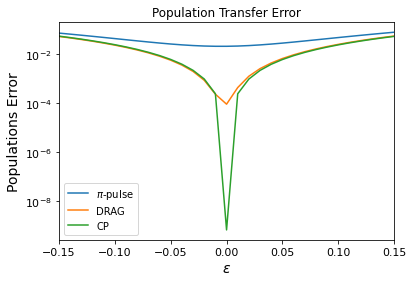

In [9]:
operator = create_gate('X',5)

parametersX = np.concatenate((pop_transfer_short,np.ones(number_of_pulses)*t_g/number_of_pulses))

_  = plot_results(parametersX,True,number_of_pulses,5,operator = False, G = operator,gate = 'X')